In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestRegressor

In [3]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [4]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [5]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [6]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [7]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


## FEATURE ENGINEERING

LTV Calculation

In [8]:
# Calculation of LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [9]:
joint_data['LTV'] = joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13


In [10]:
# Tier LTV 
joint_data['LTV_Tier'] = pd.qcut(joint_data['LTV'], 3, labels=['low', 'medium', 'high'])

In [27]:
# PREP LTV for CATEGORICAL COLUMN 
def LTV_Categorical(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3

In [28]:
joint_data['LTV_Categorical'] = joint_data['LTV_Tier'].apply(LTV_Categorical)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased,Avg_Transaction_Time,LTV_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,118 days,584.913333,medium,75 days,75,118,inactive online,2+ months ago,19.666667,1
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,777 days,675.702222,high,219 days,219,777,actively engaged,2+ months ago,86.333333,2
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,544 days,242.478333,low,551 days,551,544,actively engaged,2+ months ago,90.666667,1
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,243 days,393.734000,low,638 days,638,243,actively engaged,2+ months ago,12.150000,2
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,494 days,646.856250,medium,364 days,364,494,actively engaged,2+ months ago,20.583333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,240 days,549.820000,medium,292 days,292,240,actively engaged,2+ months ago,24.000000,2
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,200 days,487.358333,low,492 days,492,200,inactive online,2+ months ago,16.666667,2
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,135 days,1167.710000,high,122 days,122,135,regularly checks online,2+ months ago,45.000000,1


DATA PREP

In [11]:
# Convert transaction_date to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [12]:
# customer age (How long they have been a member)
joint_data['Customer_Age'] = pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])
joint_data['Customer_Age']

customer_id
1       118 days
2       777 days
3       544 days
4       243 days
5       494 days
          ...   
9996    240 days
9997    200 days
9998    135 days
9999     66 days
10000    98 days
Name: Customer_Age, Length: 10000, dtype: timedelta64[ns]

In [13]:
# Avg transaction amount
joint_data['Avg_Transaction_Amount'] = (joint_data['LTV'])/(joint_data['transaction_id'])
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,LTV_Tier,Customer_Age,Avg_Transaction_Amount
customer_id,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,low,118 days,584.913333
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,medium,777 days,675.702222
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,low,544 days,242.478333
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,medium,243 days,393.734000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,high,494 days,646.856250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,medium,240 days,549.820000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,medium,200 days,487.358333
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,low,135 days,1167.710000


In [14]:
# Tier Avg Spend
joint_data['Avg_Spending_Tier'] = pd.qcut(joint_data['Avg_Transaction_Amount'], 3, labels=['low', 'medium', 'high'])

In [29]:
# PREP Avg Spend for CATEGORICAL COLUMN 
def Avg_Spend_Categorical(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3

In [30]:
joint_data['Avg_Spend_Categorical'] = joint_data['Avg_Spending_Tier'].apply(Avg_Spend_Categorical)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Transaction_Amount,Avg_Spending_Tier,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased,Avg_Transaction_Time,LTV_Categorical,Avg_Spend_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,584.913333,medium,75 days,75,118,inactive online,2+ months ago,19.666667,1,2
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,675.702222,high,219 days,219,777,actively engaged,2+ months ago,86.333333,2,3
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,242.478333,low,551 days,551,544,actively engaged,2+ months ago,90.666667,1,1
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,393.734000,low,638 days,638,243,actively engaged,2+ months ago,12.150000,2,1
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,646.856250,medium,364 days,364,494,actively engaged,2+ months ago,20.583333,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,549.820000,medium,292 days,292,240,actively engaged,2+ months ago,24.000000,2,2
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,487.358333,low,492 days,492,200,inactive online,2+ months ago,16.666667,2,1
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,1167.710000,high,122 days,122,135,regularly checks online,2+ months ago,45.000000,1,3


In [15]:
# Most Recent Purchase (in days)
joint_data['most_recent_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'].max()) - pd.to_datetime(joint_data['last_purchase_date'])

In [16]:
# convert to an integer number of days for most recent purchase
joint_data['most_recent_purchase_in_days'] = joint_data['most_recent_purchase_date'].dt.days

In [17]:
# convert to an integer number of days for customer age
joint_data['Customer_Age_in_days']=joint_data['Customer_Age'].dt.days

In [18]:
# Customer Engagement (based on how much their site visits)
def Customer_Engagement(x):
    if x<=10:
        return 'inactive online'
    if x>=11 and x<100:
        return 'regularly checks online'
    if x>=100:
        return 'actively engaged'
    else:
        return 'member'

In [19]:
joint_data['Customer_Engagement'] = joint_data['number_of_site_visits'].apply(Customer_Engagement)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,LTV_Tier,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement
customer_id,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,low,118 days,584.913333,medium,75 days,75,118,inactive online
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,medium,777 days,675.702222,high,219 days,219,777,actively engaged
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,low,544 days,242.478333,low,551 days,551,544,actively engaged
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,medium,243 days,393.734000,low,638 days,638,243,actively engaged
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,high,494 days,646.856250,medium,364 days,364,494,actively engaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,medium,240 days,549.820000,medium,292 days,292,240,actively engaged
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,medium,200 days,487.358333,low,492 days,492,200,inactive online
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,low,135 days,1167.710000,high,122 days,122,135,regularly checks online


In [48]:
# Gender for CATEGORICAL COLUMN 
def Gender_Categorical(x):
    if x == 'Male':
        return 1
    elif x == 'Female':
        return 2
    else:
        return 0

In [51]:
joint_data['Gender_Categorical'] = joint_data['gender'].apply(Gender_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased,Avg_Transaction_Time,LTV_Categorical,Avg_Spend_Categorical,Engage_Categorical,Gender_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,75 days,75,118,inactive online,2+ months ago,19.666667,1,2,1,2
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,219 days,219,777,actively engaged,2+ months ago,86.333333,2,3,3,1
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,551 days,551,544,actively engaged,2+ months ago,90.666667,1,1,3,0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,638 days,638,243,actively engaged,2+ months ago,12.150000,2,1,3,1
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,364 days,364,494,actively engaged,2+ months ago,20.583333,3,2,3,1


In [31]:
# PREP Engagement for CATEGORICAL COLUMN 
def Engage_Categorical(x):
    if x == 'inactive online':
        return 1
    elif x == 'regularly checks online':
        return 2
    elif x == 'actively engaged':
        return 3

In [32]:
joint_data['Engage_Categorical'] = joint_data['Customer_Engagement'].apply(Engage_Categorical)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spending_Tier,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased,Avg_Transaction_Time,LTV_Categorical,Avg_Spend_Categorical,Engage_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,medium,75 days,75,118,inactive online,2+ months ago,19.666667,1,2,1
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,high,219 days,219,777,actively engaged,2+ months ago,86.333333,2,3,3
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,551 days,551,544,actively engaged,2+ months ago,90.666667,1,1,3
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,low,638 days,638,243,actively engaged,2+ months ago,12.150000,2,1,3
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,medium,364 days,364,494,actively engaged,2+ months ago,20.583333,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,medium,292 days,292,240,actively engaged,2+ months ago,24.000000,2,2,3
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,low,492 days,492,200,inactive online,2+ months ago,16.666667,2,1,1
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,high,122 days,122,135,regularly checks online,2+ months ago,45.000000,1,3,2


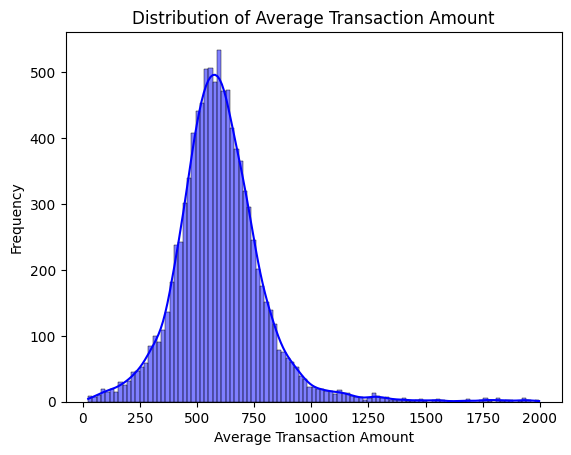

In [20]:
# Histogram to determine data distribution
sns.histplot(joint_data['Avg_Transaction_Amount'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transaction Amount')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Recently purchased (tiering based on how recent their last purchase was)
def Recently_Purchased(x):
    if x<=14:
        return '2 weeks or less'
    if x>=15 and x<59:
        return '1-2 months ago'
    if x>=60:
        return '2+ months ago'
    else:
        return 'not applicable'

In [22]:
joint_data['Recently_Purchased'] = joint_data['most_recent_purchase_in_days'].apply(Recently_Purchased)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV,LTV_Tier,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,3509.48,low,118 days,584.913333,medium,75 days,75,118,inactive online,2+ months ago
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,6081.32,medium,777 days,675.702222,high,219 days,219,777,actively engaged,2+ months ago
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,1454.87,low,544 days,242.478333,low,551 days,551,544,actively engaged,2+ months ago
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,7874.68,medium,243 days,393.734000,low,638 days,638,243,actively engaged,2+ months ago
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,15524.55,high,494 days,646.856250,medium,364 days,364,494,actively engaged,2+ months ago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,5498.20,medium,240 days,549.820000,medium,292 days,292,240,actively engaged,2+ months ago
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,5848.30,medium,200 days,487.358333,low,492 days,492,200,inactive online,2+ months ago
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,3503.13,low,135 days,1167.710000,high,122 days,122,135,regularly checks online,2+ months ago


In [23]:
# Avg Transaction Time = how often do they make a transaction (in days)
joint_data['Avg_Transaction_Time'] = joint_data['Customer_Age_in_days']/joint_data['transaction_id']
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV_Tier,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,low,118 days,584.913333,medium,75 days,75,118,inactive online,2+ months ago,19.666667
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,medium,777 days,675.702222,high,219 days,219,777,actively engaged,2+ months ago,86.333333
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,544 days,242.478333,low,551 days,551,544,actively engaged,2+ months ago,90.666667
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,medium,243 days,393.734000,low,638 days,638,243,actively engaged,2+ months ago,12.150000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,high,494 days,646.856250,medium,364 days,364,494,actively engaged,2+ months ago,20.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,medium,240 days,549.820000,medium,292 days,292,240,actively engaged,2+ months ago,24.000000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,medium,200 days,487.358333,low,492 days,492,200,inactive online,2+ months ago,16.666667
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,low,135 days,1167.710000,high,122 days,122,135,regularly checks online,2+ months ago,45.000000


## RFM (1 MONTH, 3 MONTHS, 6 MONTHS, 12 MONTHS)

RFM PREP

In [24]:
# Convert the 'date' column to datetime type
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [25]:
# set reference date
last_date = transactions['transaction_date'].max()

In [35]:
def calculate_rfm(data, end_date, days_label):
    rfm = data.groupby('customer_id').agg(
        recency = ('transaction_date', lambda x: (end_date - x.max()).days),
        frequency = ('transaction_id', 'count'),
        monetary = ('transaction_amount', 'sum')
    ).rename(columns={
        'recency': f'Recency_{days_label}',
        'frequency': f'Frequency_{days_label}',
        'monetary': f'Monetary_{days_label}'
    })
    return rfm

1 MONTH

In [33]:
# Define the time periods
days_30 = last_date - timedelta(days=30)

In [34]:
last_30_days = transactions[(transactions['transaction_date'] > days_30) & (transactions['transaction_date'] <= last_date)]

In [38]:
rfm_30 = calculate_rfm(last_30_days, last_date, '30')
rfm_30
# Conclusion: not enough data to conduct any modeling for rfm on last 30 days

,Recency_30,Frequency_30,Monetary_30
customer_id,,,
7,13,3,1018.16
48,19,1,439.69
59,24,8,4848.62
66,8,20,10795.72
90,1,19,11212.55
...,...,...,...
9869,28,1,408.71
9873,1,20,8405.83
9875,28,1,114.28


3 MONTHS

In [40]:
days_90 = last_date - timedelta(days=90)

In [41]:
last_90_days = transactions[(transactions['transaction_date'] > days_90) & (transactions['transaction_date'] <= last_date)]

In [42]:
rfm_90 = calculate_rfm(last_90_days, last_date, '90')
rfm_90

,Recency_90,Frequency_90,Monetary_90
customer_id,,,
1,80,1,146.86
7,13,3,1018.16
21,42,1,148.29
37,56,4,2136.82
38,65,2,299.14
...,...,...,...
9956,74,1,318.59
9973,50,6,4729.27
9976,49,2,456.78


In [45]:
# RFM Score Creation for 3 months
# Scoring Recency: Lower recency is better
rfm_90['R_Score'] = pd.qcut(rfm_90['Recency_90'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rfm_90['F_Score'] = pd.qcut(rfm_90['Frequency_90'], 4, labels=[1, 2, 3, 4])
rfm_90['M_Score'] = pd.qcut(rfm_90['Monetary_90'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rfm_90['RFM_Score'] = rfm_90['R_Score'].astype(int) + rfm_90['F_Score'].astype(int) + rfm_90['M_Score'].astype(int)
rfm_90.head()

,Recency_90,Frequency_90,Monetary_90,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
1,80,1,146.86,1,1,1,3
7,13,3,1018.16,4,2,1,7
21,42,1,148.29,3,1,1,5
37,56,4,2136.82,2,2,2,6
38,65,2,299.14,2,1,1,4


In [52]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Recently_Purchased,Avg_Transaction_Time,LTV_Categorical,Avg_Spend_Categorical,Engage_Categorical,Gender_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,75 days,75,118,inactive online,2+ months ago,19.666667,1,2,1,2
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,219 days,219,777,actively engaged,2+ months ago,86.333333,2,3,3,1
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,551 days,551,544,actively engaged,2+ months ago,90.666667,1,1,3,0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,638 days,638,243,actively engaged,2+ months ago,12.150000,2,1,3,1
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,364 days,364,494,actively engaged,2+ months ago,20.583333,3,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,292 days,292,240,actively engaged,2+ months ago,24.000000,2,2,3,2
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,492 days,492,200,inactive online,2+ months ago,16.666667,2,1,1,1
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,122 days,122,135,regularly checks online,2+ months ago,45.000000,1,3,2,1


In [54]:
rfm_90['90_day_avg'] = (rfm_90['Monetary_90'])/(rfm_90['Frequency_90'])

In [55]:
rfm_90 = pd.merge(rfm_90, joint_data[['join_date', 'age', 'number_of_site_visits', 'most_recent_purchase_in_days', 'Customer_Age_in_days','Customer_Engagement', 'LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']], on='customer_id', how='left')
rfm_90.head()

,Recency_90,Frequency_90,Monetary_90,R_Score,F_Score,M_Score,RFM_Score,join_date_x,age_x,number_of_site_visits_x,...,join_date_y,age_y,number_of_site_visits_y,most_recent_purchase_in_days_y,Customer_Age_in_days_y,Customer_Engagement_y,LTV_Categorical_y,Avg_Spend_Categorical_y,Engage_Categorical_y,Gender_Categorical_y
customer_id,,,,,,,,,,,,,,,,,,,,,
1,80,1,146.86,1,1,1,3,2023-11-20,56.0,10,...,2023-11-20,56.0,10,75,118,inactive online,1,2,1,2
7,13,3,1018.16,4,2,1,7,2023-12-11,NaN,64,...,2023-12-11,NaN,64,2,170,regularly checks online,1,1,2,2
21,42,1,148.29,3,1,1,5,2023-04-07,20.0,187,...,2023-04-07,20.0,187,14,406,actively engaged,2,3,3,1
37,56,4,2136.82,2,2,2,6,2023-06-17,54.0,34,...,2023-06-17,54.0,34,39,310,regularly checks online,2,2,2,2
38,65,2,299.14,2,1,1,4,2023-02-27,NaN,101,...,2023-02-27,NaN,101,62,397,actively engaged,2,2,3,2


## MODEL TESTING

90 DAY RFM